In [1]:
import torch, torch.nn as nn, torch.nn.functional as F, torch.optim as optim
import numpy as np
from einops import rearrange, repeat
from torch import einsum

In [2]:
class DynamicPositionBias(nn.Module):
    def __init__(self, dim, *, heads, depth, log_distance = False, norm = False):
        super().__init__()
        assert depth >= 1, 'depth for dynamic position bias MLP must be greater or equal to 1'
        self.log_distance = log_distance

        self.mlp = nn.ModuleList([])

        self.mlp.append(nn.Sequential(
            nn.Linear(1, dim),
            nn.LayerNorm(dim) if norm else nn.Identity(),
            nn.ReLU()
        ))

        for _ in range(depth - 1):
            self.mlp.append(nn.Sequential(
                nn.Linear(dim, dim),
                nn.LayerNorm(dim) if norm else nn.Identity(),
                nn.ReLU()
            ))

        self.mlp.append(nn.Linear(dim, heads))

    def forward(self, n, device, dtype):

        # get the (n x n) matrix of distances
        seq_arange = torch.arange(n, device = device)
        context_arange = torch.arange(n, device = device)
        indices = rearrange(seq_arange, 'i -> i 1') - rearrange(context_arange, 'j -> 1 j')
        indices += (n - 1)
        
        # input to continuous positions MLP
        pos = torch.arange(-n + 1, n, device = device, dtype = dtype)
        pos = rearrange(pos, '... -> ... 1')

        if self.log_distance:
            pos = torch.sign(pos) * torch.log(pos.abs() + 1)  # log of distance is sign(rel_pos) * log(abs(rel_pos) + 1)

        for layer in self.mlp:
            pos = layer(pos)

        # get position biases        
        bias = pos[indices]
        bias = rearrange(bias, 'i j h -> h i j')
        return bias

torch.Size([5, 9, 94, 32, 64]) dots

In [3]:
dots = torch.randn(5, 9, 94, 32, 64)

In [4]:
Dpos = DynamicPositionBias(219, heads = 9, depth = 2)
pos = Dpos(3008, device = 'cpu', dtype = torch.float32)
print(pos.shape)
# duplicate for batch
pos = repeat(pos, 'h i j -> b h i j', b = 5)
pos = rearrange(pos, 'b h (n i) j -> b h n i j', i = 32)
print(pos.shape)
pos = pos[repeat(km[0], 'b h nw n -> b h nw i n', i = 32)]
# rshape to dots shape
pos = pos.reshape(*dots.shape)
print(pos.shape)

torch.Size([9, 3008, 3008])
torch.Size([5, 9, 94, 32, 3008])


NameError: name 'km' is not defined

In [5]:
pos.reshape(5, 9, 94, 32, -1).shape

torch.Size([5, 9, 94, 32, 3008])

In [6]:
pos[repeat(km[0], 'b h nw n -> b h nw i n', i = 32)]

NameError: name 'km' is not defined

In [7]:
km.shape

NameError: name 'km' is not defined

In [8]:
def ChunkGrid(Total_Size, Block_Size):
    Psize = Total_Size // Block_Size
    chunk_grid = (torch.arange(0, Psize).repeat(Psize,1) - torch.arange(0, Psize).repeat(Psize,1).T ).repeat_interleave(Block_Size, dim=1).abs()
    return chunk_grid

In [9]:
ChunkGrid(3008, 32)

tensor([[ 0,  0,  0,  ..., 93, 93, 93],
        [ 1,  1,  1,  ..., 92, 92, 92],
        [ 2,  2,  2,  ..., 91, 91, 91],
        ...,
        [91, 91, 91,  ...,  2,  2,  2],
        [92, 92, 92,  ...,  1,  1,  1],
        [93, 93, 93,  ...,  0,  0,  0]])

In [10]:
def ChunkGrid(Total_Size, Block_Size):
    Psize = Total_Size // Block_Size
    chunk_grid = (torch.arange(0, Psize).repeat(Psize,1) - torch.arange(0, Psize).repeat(Psize,1).T ).repeat_interleave(Block_Size, dim=1).abs()
    #chunk_grid = 1 - (chunk_grid / chunk_grid.max(dim=-1)[0].unsqueeze(-1))
    
    return chunk_grid

In [11]:
chunkgrid = ChunkGrid(4800, 48)
pareto = torch.distributions.pareto.Pareto(torch.tensor(3.0), torch.tensor(2.0)).sample(chunkgrid.shape)
chunkgrid = chunkgrid - pareto

column = 0
print(chunkgrid[column].topk(384, largest=False).indices.max())
chunkgrid[column].topk(384, largest=False).indices.sort(-1).values

tensor(4629)


tensor([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
          12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,
          24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
          36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,   47,
          48,   49,   50,   51,   52,   53,   54,   55,   56,   57,   58,   59,
          60,   61,   62,   63,   64,   65,   66,   67,   68,   69,   70,   71,
          72,   73,   74,   75,   76,   77,   78,   79,   80,   81,   82,   83,
          84,   85,   86,   87,   88,   89,   90,   91,   92,   93,   94,   95,
          96,   97,   98,   99,  100,  101,  102,  103,  104,  105,  106,  107,
         108,  109,  110,  111,  112,  113,  114,  115,  116,  117,  118,  119,
         120,  121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
         132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,  143,
         144,  145,  146,  147,  148,  1

In [12]:
chunkgrid.shape

torch.Size([100, 4800])

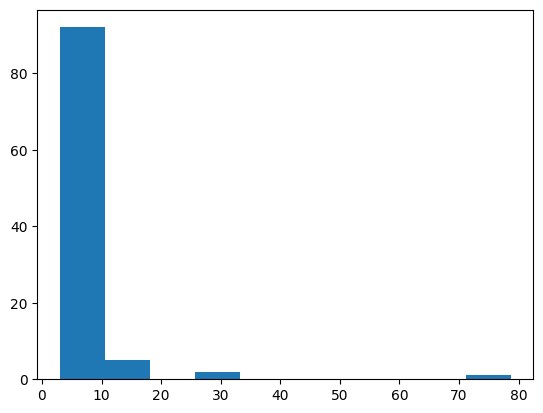

In [15]:
dist = torch.distributions.pareto.Pareto(3, 2).sample(torch.tensor([100]))
plt.hist(dist)
plt.show()

In [16]:
print(chunkgrid[0].topk(40, largest=False).indices.max())
chunkgrid[0].topk(40, largest=False).indices


tensor(4629)


tensor([3703, 1581, 1611, 1851, 1453,  427, 2174,  200,  924,  697, 1148,  412,
         538, 4629,  519,  210,  918, 1832,  419, 1167, 1703, 2862,  235, 1193,
        2637,  637,   30,  164,  275,  278,  667,   53, 3444,  195,  399,  163,
         342,  159, 1598,   27])

In [46]:
def exists(val):
    return val is not None

class DynamicPositionBias(nn.Module):
    def __init__(self, dim, *, heads, depth, log_distance = False, norm = False):
        super().__init__()
        assert depth >= 1, 'depth for dynamic position bias MLP must be greater or equal to 1'
        self.log_distance = log_distance

        self.mlp = nn.ModuleList([])

        self.mlp.append(nn.Sequential(
            nn.Linear(1, dim),
            nn.LayerNorm(dim) if norm else nn.Identity(),
            nn.ReLU()
        ))

        for _ in range(depth - 1):
            self.mlp.append(nn.Sequential(
                nn.Linear(dim, dim),
                nn.LayerNorm(dim) if norm else nn.Identity(),
                nn.ReLU()
            ))

        self.mlp.append(nn.Linear(dim, heads))

    def forward(self, n, device, dtype):

        # get the (n x n) matrix of distances
        seq_arange = torch.arange(n, device = device)
        context_arange = torch.arange(n, device = device)
        indices = rearrange(seq_arange, 'i -> i 1') - rearrange(context_arange, 'j -> 1 j')
        indices += (n - 1)
        
        # input to continuous positions MLP
        pos = torch.arange(-n + 1, n, device = device, dtype = dtype)
        pos = rearrange(pos, '... -> ... 1')

        if self.log_distance:
            pos = torch.sign(pos) * torch.log(pos.abs() + 1)  # log of distance is sign(rel_pos) * log(abs(rel_pos) + 1)

        for layer in self.mlp:
            pos = layer(pos)

        # get position biases        
        bias = pos[indices]
        bias = rearrange(bias, 'i j h -> h i j')
        return bias

class MyopicAttention(nn.Module):
    def __init__(
        self,
        n_feats,
        head_dim,
        n_heads,
        dropout=0.0,
        max_keep_keys=50,
        chunk_window=3,
        bias=True,
        return_attention=False,
    ):
        super().__init__()
        self.n_feats = n_feats
        self.head_dim = head_dim
        self.n_heads = n_heads
        self.dropout = dropout
        self.bias = bias
        self.return_attention = return_attention

        self.scale = head_dim ** -0.5

        self.max_keep_keys = max_keep_keys
        self.W = chunk_window

        self.positional_bias = DynamicPositionBias(
            dim = n_feats,
            heads = n_heads,
            depth = 2,
            log_distance = False,
            norm = False
        )

        self.qkv_proj = nn.Linear(n_feats, 3 * n_heads * head_dim, bias=bias)
        self.out_proj = nn.Linear(n_heads * head_dim, n_feats, bias=bias)

    def pad_to_window_size(self, x, window_size, axis=3, mask=None):
        """
        Pad the input on two sides to be divisible by `window_size`
        """
        QKV, batch_size, heads, sequence_length, hidden_size = x.shape
        padding_length = (window_size - sequence_length % window_size) % window_size
        padding = torch.zeros(QKV, batch_size, heads, padding_length, hidden_size,
            device=x.device,
            dtype=x.dtype,
        )
        mask = F.pad(mask, (0, padding_length), value=True) if exists(mask) else None
        return torch.cat([x, padding], axis=axis), padding_length, mask

    def unpad(self, x, padding_length):
        """
        Undo padding.
        """
        if padding_length > 0:
            return x[:, :-padding_length]
        return x

    def ChunkGrid(self, Total_Size, Block_Size):
        Psize = Total_Size // Block_Size
        chunk_grid = (torch.arange(0, Psize).repeat(Psize,1) - torch.arange(0, Psize).repeat(Psize,1).T ).repeat_interleave(Block_Size, dim=1).abs()
        chunk_grid = 1 - (chunk_grid / chunk_grid.max(dim=-1)[0].unsqueeze(-1))
        return chunk_grid    

    def forward(self, x, mask=None, return_attention=False):
        B, N, C, H, D = *x.shape, self.n_heads, self.head_dim
        tokeep = min(self.max_keep_keys, N) if self.max_keep_keys != -1 else N
        W = min(self.W, N) if self.W != -1 else N
        qkv = rearrange(self.qkv_proj(x), "B N (H D QKV) -> QKV B H N D", QKV=3, H=H, D=D)

        qkv, pad_n, mask = self.pad_to_window_size(qkv, W, axis=3, mask=mask)
        q, kv = qkv[0], qkv[1:]
        # split q into windows/chunks of size W
        q = rearrange(q, "B H (N W) D -> B H N W D", W=W)
        if exists(mask):
            q_mask = rearrange(mask, "B (N W) -> B N W", W=W)
            q_mask = repeat(q_mask, "B N W -> B H N W", H=H)
            
        # duplicate k and v for total number of windows
        kv = repeat(kv, "KV B H N D -> KV B H NW N D", NW=q.shape[2])
        #print(q.shape, kv.shape)
        KV, B, H, NW, N, D = kv.shape

        chunkgrid = self.ChunkGrid(Total_Size=N, Block_Size=W).to(q.device)
        
        chunkgrid = repeat(chunkgrid, "W N -> B H W N", B=B, H=H).contiguous()
        MEAN = torch.tensor(0, device=q.device, dtype=q.dtype)
        STD = torch.tensor(0.125, device=q.device, dtype=q.dtype)
        uniform_dist = torch.distributions.normal.Normal(MEAN, STD).sample(chunkgrid.shape).to(q.device)
        chunkgrid += uniform_dist
        chunkgrid = repeat(chunkgrid, "B H W N -> KV B H W N", KV=2)

        print(chunkgrid.shape, 'cg')
        cmask = repeat(mask, 'B N -> KV B H NW N', KV=2, H=H, NW=NW)
        
        chunkgrid.masked_fill_(mask=cmask, value=-torch.finfo(q.dtype).max) ########
       
        keep_indices = chunkgrid.topk(k=tokeep, dim=-1, sorted=False).indices.sort(dim=-1).values
        KV, B, H, NW, N, D = kv.shape 
        kv = kv.gather(-2, repeat(keep_indices, "KV B H W N -> KV B H W N D", D=D))

        if exists(mask):
            kv_mask = repeat(mask, "B N -> B H NW N", H=H, NW=NW).gather(-1, keep_indices[0])

        k, v = kv
        # NW (number of windows) = P (in below einsum)
        dots = einsum("B H N P D, B H N Z D -> B H N P Z ", q, k) * self.scale # Z is number of chunks in Q, N is max sequence length after dropping

        ## positional stuff
        pos_bias = self.positional_bias(N, device=dots.device, dtype=dots.dtype)
        pos_bias = repeat(pos_bias, 'H I J -> B H I J', B = B)
        pos_bias = rearrange(pos_bias, 'B H (N W) J -> B H N W J', W = W)

        pos_bias = pos_bias.gather(-1, repeat(keep_indices, "KV B H NW N -> KV B H NW W N", W=W)[0])
        
        dots = dots + pos_bias

        if exists(mask):
            mask_val = -torch.finfo(dots.dtype).max
            qk_mask = rearrange(q_mask, "B H N W -> B H N W ()") * rearrange(kv_mask, "B H W N -> B H W () N")
            dots.masked_fill_(qk_mask, mask_val)

        attn = dots.softmax(dim=-1)
  
        out = einsum("B H N W Z, B H N Z D -> B H N W D", attn, v)
        out = rearrange(out, "B H N W D -> B (N W) (H D)")
        out = self.unpad(out, pad_n)
        out = self.out_proj(out)
        return out if not return_attention else (out, attn)

        

In [47]:
attention = MyopicAttention(n_feats=216, head_dim=24, n_heads=12, max_keep_keys=-1, chunk_window=-1)

attn = attention(x, mask)

torch.Size([2, 10, 12, 1, 1000]) cg


/tmp/ipykernel_1090470/3731934327.py:144: UserWarning: Use of masked_fill_ on expanded tensors is deprecated. Please clone() the tensor before performing this operation. This also applies to advanced indexing e.g. tensor[mask] = scalar (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:1398.)
  chunkgrid.masked_fill_(mask=cmask, value=-torch.finfo(q.dtype).max)


In [19]:
print(mydots.shape, normaldots.shape)

NameError: name 'mydots' is not defined

In [440]:
mydots = mydots.permute(0, 3, 4, 1, 2).reshape(*[10, 1000, 288])

In [409]:
assert torch.allclose(normaldots, mydots.squeeze()), "we are not the same"
print('woop')

woop


In [442]:
torch.allclose(normaldots.reshape(*[10, 1000, 288]), mydots.reshape(*[10, 1000, 288]))

False

In [441]:
normaldots = rearrange(normaldots, 'b h n d -> b n (h d)')
#mydots = rearrange(mydots, 'b h w n d -> b (w n) (h d)')
mydots = mydots.squeeze()
print(normaldots.shape, mydots.shape)

torch.Size([10, 1000, 288]) torch.Size([10, 1000, 288])


In [379]:
second_column =0
last_column = 20

print(normaldots.reshape(*[10, 1000, 288])[0][second_column][last_column])
print(mydots.reshape(*[10, 1000, 288])[0][second_column][last_column])

tensor(-0.2519, grad_fn=<SelectBackward0>)
tensor(-0.2519, grad_fn=<SelectBackward0>)


In [21]:
x = torch.randn(10, 1000, 216)
mask = torch.zeros(10, 1000).bool()

In [74]:
o[0][0].shape

torch.Size([288])

In [73]:
v.reshape(o.shape)[0][0].shape

torch.Size([288])

In [31]:
o.shape

torch.Size([10, 1000, 288])

In [29]:
o[0][0]

tensor([ 3.6628e-02, -3.9733e-03, -1.6485e-01, -1.3621e-01, -8.7017e-02,
         1.3378e-01,  4.9637e-03, -4.1894e-03, -7.3796e-02,  8.6580e-03,
        -1.3460e-01, -1.0907e-01,  1.7497e-01, -4.9137e-03,  2.2401e-01,
         1.4699e-01,  1.7687e-01,  7.0131e-02, -1.3558e-01, -8.2851e-02,
        -8.5467e-02, -6.2461e-02, -1.3721e-03, -7.3953e-02,  7.2629e-02,
        -6.8547e-02,  5.5272e-02, -3.2858e-02, -3.7293e-02,  5.0426e-02,
         3.0691e-02, -1.0333e-02, -1.6956e-02, -3.3131e-02, -1.0702e-01,
        -3.0205e-02,  3.5606e-02,  5.2930e-02, -4.2927e-02, -1.7174e-02,
        -3.1038e-02, -4.6316e-02,  4.0095e-02, -5.3015e-02, -2.8979e-02,
         4.9179e-02,  3.0483e-03,  6.9603e-02, -3.3213e-01, -1.8481e-01,
        -1.2169e-01, -2.3707e-02, -7.8052e-02, -4.6261e-02, -9.8207e-02,
         2.3057e-01, -8.5172e-02, -8.0997e-02, -2.8267e-01, -2.6922e-01,
         1.1706e-01,  3.6214e-01,  7.5635e-04,  1.8275e-01,  1.9320e-01,
         4.1853e-01, -2.0188e-01,  2.9349e-01,  2.7

In [415]:
v.reshape(o.shape)[0][0]

tensor([ 0.0158,  0.0995, -0.0365, -0.1100,  0.0334,  0.0426, -0.0559, -0.0099,
        -0.0433, -0.0294,  0.0380,  0.1200,  0.0432, -0.0370,  0.0225,  0.0208,
        -0.0936, -0.0647,  0.0883, -0.0521,  0.0226, -0.0264,  0.0386, -0.0356,
        -0.0234,  0.0948, -0.0419, -0.0824,  0.0371, -0.0042, -0.0448, -0.0239,
        -0.0418, -0.0161,  0.0216,  0.0818,  0.0284, -0.0340, -0.0004,  0.0185,
        -0.0729, -0.0705,  0.0572, -0.0349,  0.0030, -0.0103, -0.0111,  0.0069,
         0.0322,  0.1101, -0.0391, -0.0739,  0.0429,  0.0121, -0.0368, -0.0178,
        -0.0605, -0.0355,  0.0520,  0.0599,  0.0368, -0.0061,  0.0401,  0.0240,
        -0.0522, -0.0404,  0.0357, -0.0948, -0.0124, -0.0013, -0.0035, -0.0068,
         0.0026,  0.0847, -0.0310, -0.0910,  0.0488,  0.0197, -0.0570, -0.0149,
        -0.0368, -0.0208,  0.0392,  0.0997,  0.0276, -0.0124,  0.0138,  0.0275,
        -0.0865, -0.0496,  0.0638, -0.0559, -0.0021, -0.0384,  0.0196, -0.0367,
        -0.0062,  0.0923, -0.0444, -0.08

In [397]:
attn.shape

torch.Size([10, 12, 125, 8, 256])

In [ ]:
a.indices.sort().values[0, 0, 0, 0]

In [ ]:
torch.tensor(2).unsqueeze(-1).repeat(2).expand(2, 2)

In [ ]:
torch.randn()

In [ ]:
km.shape

In [ ]:
km[0, 0, :, 0, :100].sum(-1)

In [ ]:
km.shape

In [ ]:
(torch.arange(0, 3008).repeat(3008,1) - torch.arange(0, 3008).repeat(3008,1).T).reshape(32, -1, 3008).shape

- duplicated across KV
- each batch, head and Window have a different view of the keys
- 94 is the number of windows i.e 94*32(win size) = 3008 (sequence length)

In [ ]:
kv.shape

In [ ]:
kv[km].reshape(2, 5, 8, 3, -1, 24).shape

In [ ]:
repeat(cg, "W N -> KV B H W N", B=5, H=8, KV=2).shape

In [ ]:
kv.s

In [ ]:
def ChunkGrid(N_BLOCKS, BLOCK_SIZE):
    chunk_grid = (torch.arange(0, N_BLOCKS).repeat(BLOCK_SIZE,1) - torch.arange(0, BLOCK_SIZE).repeat(N_BLOCKS,1).T).repeat_interleave(BLOCK_SIZE, dim=1).abs()
    chunk_grid = chunk_grid / chunk_grid.max(dim=-1)[0].unsqueeze(-1)
    return chunk_grid

In [ ]:
cg = ChunkGrid(41, 3)
uniform_dist = torch.distributions.uniform.Uniform(0, 1).sample(cg.shape)
cg += uniform_dist
keep_indices = cg.topk(9, dim=-1).indices
keep_mask = torch.zeros_like(cg).scatter_(1, keep_indices, 1).bool()

In [ ]:
cg.shape

In [ ]:
keep_mask